<a href="https://colab.research.google.com/github/Ayazhannn/Sentiment-Analysis-with-Naive-Bayes-Classifiers/blob/main/Sentimental_Analysis_Using_Naive_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this Colab notebook, I will explore sentiment analysis using the IMDb 50k film dataset. This dataset contains 50,000 movie reviews labeled as positive or negative, making it ideal for sentiment analysis tasks.

I'll be using the Naive-Bayes classifier, a simple yet effective algorithm for text classification. Goal of this project is to train the classifiers to accurately predict sentiment in movie reviews. Through preprocessing the text data and extracting relevant features,prepare the dataset for training.

I'll use 3 different types of Naive Bayes family
1. Multinomail NB
2. Bernoulli NB
3. Complement NB

Then, i'll evaluate the classifier's performance using metrics such as accuracy.


Dataset from https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import math
import nltk
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/MLdata/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Exploritary Data Analysis

In [6]:
#sentiment count
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

It shows that both classes has balanced number of reviews.

<Axes: >

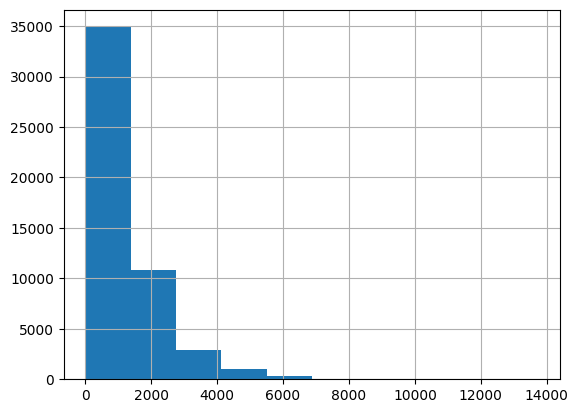

In [7]:
df['review'].str.len().hist()

The histogram demonstrates that reviews range from 10 to 1700 characters. In next histogram i'll show illustrate character range for positive and negative separately.

Text(0.5, 1.0, 'Negative review count')

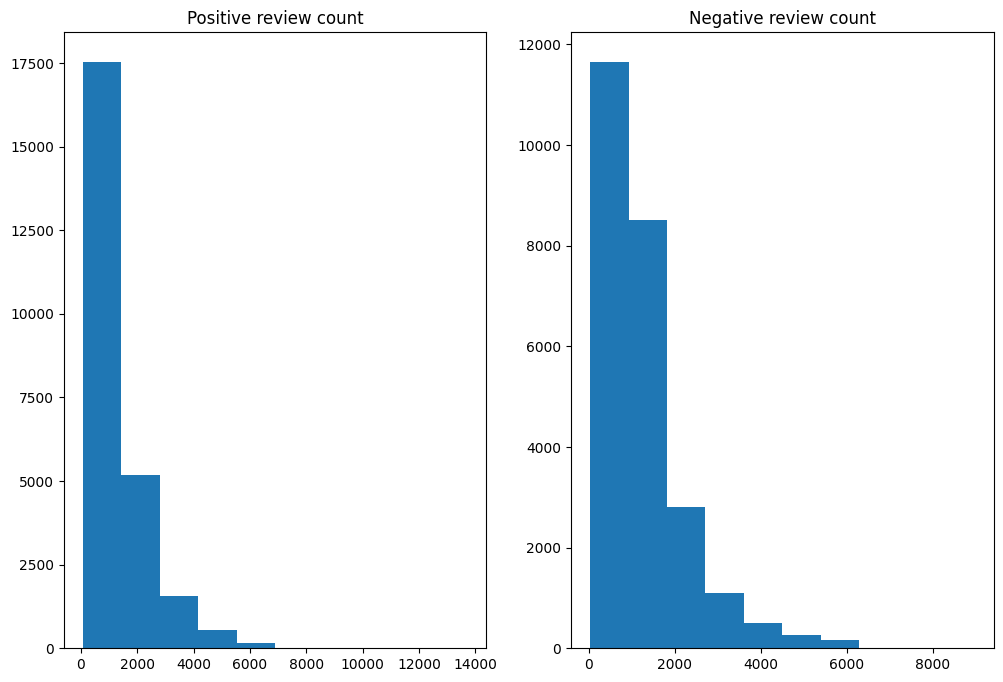

In [8]:
figs, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
ax1.hist(df[df['sentiment']=='positive']['review'].str.len())
ax1.set_title('Positive review count')
ax2.hist(df[df['sentiment']=='negative']['review'].str.len())
ax2.set_title('Negative review count')

Obseravation from these graphs:


1.   Most of positive review has range of characters from 10-1500, and in comparison to negative reviews, positive reviews tend to be shorter.



Now, we need to explore the most used words of each classes. This graph will show most used words in bigger fond and less in smaller font.

I will use Word cloud,it is one of the most powerful and straightforward visualization methods when it comes to text data. The size of words are dependent on the occurrence frequency (text's importance in the context), therefore it comes in handy for Natural Language Processing machine learning projects or text analysis like this one.

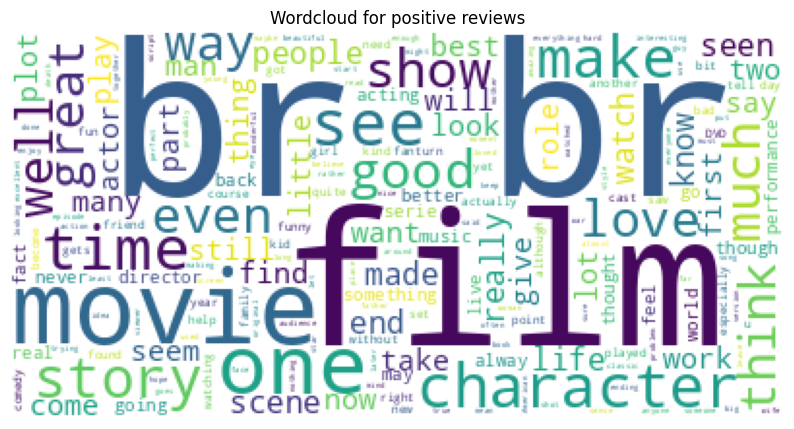

In [9]:
#WordCloud needs one single string, that is why i am joining all reviews with space between them

positive = ' '.join(i for i in df[df['sentiment']=='positive']['review'])
wc_positive = WordCloud(background_color='white').generate(positive)

plt.figure(figsize=(10,15))
plt.title('Wordcloud for positive reviews')
plt.axis('off')
plt.imshow(wc_positive)

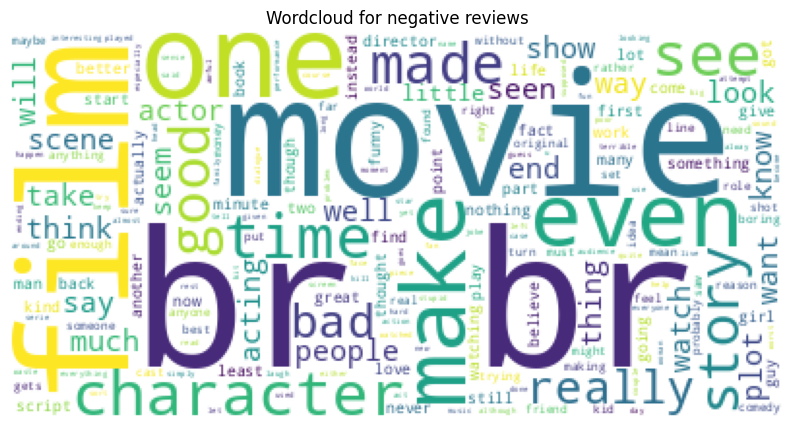

In [10]:
negative = ' '.join(i for i in df[df['sentiment']=='negative']['review'])
wc_negative = WordCloud(background_color='white').generate(negative)

plt.figure(figsize=(10,15))
plt.title('Wordcloud for negative reviews')
plt.axis('off')
plt.imshow(wc_negative)

From these charts we can't get any meaningful information,that is why there's need for data preprocessing.

# Data Preprocessing

Here i will clean data, starting from removing HTML symbols, emojis and other unneeded data.

In [11]:
def cleaning(review):
  review = review.lower() #converting to lowercase
  review = re.sub("(https?://\S+|www\.\S+)","", review) #removing website links and URLs
  review = re.sub("([\w\.\-\_]+@[\w\.\-\_]+)", "", review) #removing all email addresses
  review = re.sub("\d+","",review) #removing all digits
  review = re.sub('<.*?>+', '', review) # removing special characters
  review = re.sub("(\n+)", "", review) #removing newline characters

  return review

data = df['review'].apply(cleaning)
data.head()


0    one of the other reviewers has mentioned that ...
1    a wonderful little production. the filming tec...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: review, dtype: object

In [12]:
data = pd.DataFrame(data)
data['sentiment'] = df['sentiment']
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


Usually in data preprocessing for text based data there's need for removing stop words.
(Stop words are actually the most common words in any language and does not add much information to the text. Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”).

But dataset that i chose contains informal language, and removing stop words could actually remove valuable features relevant to sentiment. Example:

Movie review: “The movie was not good at all.”

Text after removal of stop words: “movie good”

So i will just move to next step, which is Tokenization

# Tokenization

In order to get computer to understand any text, we need to break that word down in the way machine would understand it.

So we use tokenization. It is way of breaking text into smaller pieces,we call them *tokens*. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

Consider the sentence - "Movie review"

1. Word tokenization: ["Movie", "review"]
2. Subword tokenization: ["Mo", "vi", "e", "re", "vi", "ew"]
3. Character tokenization: ["M", "o", "v", "i", "e", " ", "r", "e", "v", "i", "e", "w"]


In [13]:
# here i will create cleaned data for train test split
data.sentiment = [0 if each == 'negative' else 1 for each in data.sentiment]
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production. the filming tec...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1


In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
print(type(data['review']))

<class 'pandas.core.series.Series'>


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
tokenized_reviews = cv.fit_transform(data['review'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
X=tokenized_reviews

In [28]:
y=data['sentiment']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

# Multinomial Naive Bayes

little information on this classifier:

MultinomialNB classifier is commonly used for text classification tasks, particularly when the features are discrete counts.
It's well-suited for classification problems with multiple classes, where each feature represents the frequency of a term in a document (e.g., word counts in a text).

Despite its name, it's not limited to only multinomial distributed data; it can handle any type of count data.

In [31]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [33]:
mnb_pred = mnb.predict(X_test)

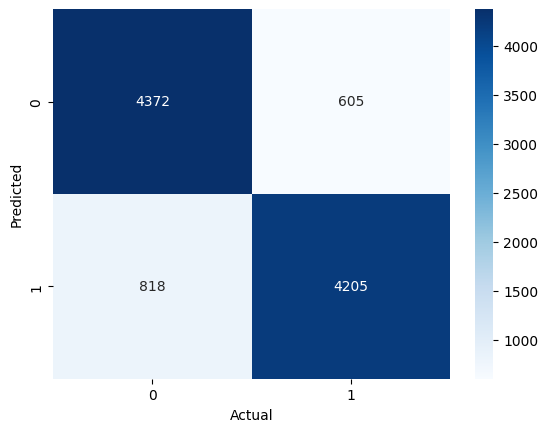

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
mnb_cfm = confusion_matrix(y_test, mnb_pred)

sns.heatmap(mnb_cfm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [35]:
print(classification_report(y_test, mnb_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4977
           1       0.87      0.84      0.86      5023

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [36]:
mnb_acc = mnb.score(X_test, y_test)
mnb_acc

0.8577

Accuracy score: is 85.77 % for the MultinomialNB model. for each of 100 total number of prediction, in average, our model can predict 86 cases correctly

The confusion matrix:

1.   Model predicted 4372 of negative reviews correctly, but misclassified 818 instances as positive
2.   Model predicted 4205 of positive reviews correctly, but misclassified 605 instances as negative


Classification Report:

Precision:

1. Negative review: the ratio correctly predicted negative review observations to the total predicted negative review observations is 0.84

2. Positive review: the ratio correctly predicted positive review observations to the total predicted positive review observations is 0.87

Recall:

1. Negative review: the ratio of correctly predicted negative review observations to the all observations in actual class is 0.88

2. Positive review: the ratio of correctly predicted positive review observations to the all observations in actual class is 0.84

F1 Score is the weighted average of Precision and Recall. In both case positive and negative review, F1 scores are equal 0.86

# Bernoulli Naive Bayes

The Bernoulli Naive-Bayes classifier is similar to the Multinomial Naive-Bayes, but it's specifically designed for binary feature vectors.
It assumes that features are binary-valued (e.g., presence or absence of a term), making it suitable for tasks where only the occurrence of features matters, not their frequencies.

It's commonly used in text classification tasks where the presence or absence of words in a document is used as features.

In [37]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

In [38]:
bnb_pred = bnb.predict(X_test)

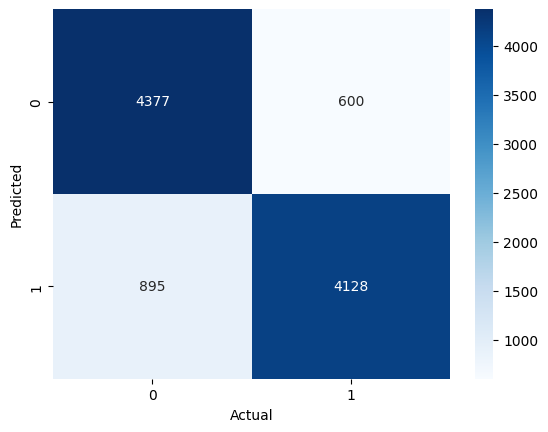

In [39]:
bnb_cfm = confusion_matrix(y_test, bnb_pred)

sns.heatmap(bnb_cfm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [40]:
print(classification_report(y_test, bnb_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4977
           1       0.87      0.82      0.85      5023

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [42]:
bnb_acc = bnb.score(X_test, y_test)
bnb_acc

0.8505

Accuracy score: is 85.05 % for the MultinomialNB model. for each of 100 total number of prediction, in average, our model can predict 85 cases correctly

The confusion matrix:

1.   Model predicted 4377 of negative reviews correctly, but misclassified 895 instances as positive
2.   Model predicted 4128 of positive reviews correctly, but misclassified 600 instances as negative


Classification Report:

Precision:

1. Negative review: the ratio correctly predicted negative review observations to the total predicted negative review observations is 0.83

2. Positive review: the ratio correctly predicted positive review observations to the total predicted positive review observations is 0.87

Recall:

1. Negative review: the ratio of correctly predicted negative review observations to the all observations in actual class is 0.88

2. Positive review: the ratio of correctly predicted positive review observations to the all observations in actual class is 0.82

F1 Score is the weighted average of Precision and Recall. In both case positive and negative review, F1 scores are equal 0.85

# Complement Naive Bayes

* The Complement Naive-Bayes classifier is a variant of the Multinomial Naive-Bayes, particularly useful for handling imbalanced datasets.

* It's designed to correct the "complement" of each class's probability, making it robust to class imbalance by adjusting for the frequency of each term in the dataset.

* It's often more effective than Multinomial Naive-Bayes on imbalanced datasets or when dealing with skewed class distributions.

In [43]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
cnb.fit(X_train, y_train)

ComplementNB()

In [44]:
cnb_pred = cnb.predict(X_test)

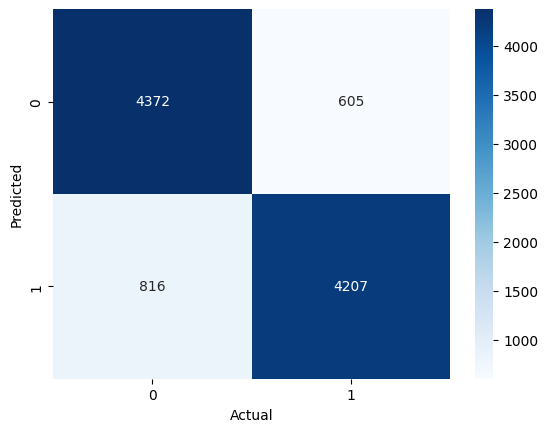

In [45]:
cnb_cfm = confusion_matrix(y_test, cnb_pred)
sns.heatmap(cnb_cfm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [46]:
print(classification_report(y_test, cnb_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4977
           1       0.87      0.84      0.86      5023

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [47]:
cnb_acc = cnb.score(X_test, y_test)
cnb_acc

0.8579

Accuracy score: is 85.79 % for the MultinomialNB model. for each of 100 total number of prediction, in average, our model can predict 86 cases correctly

The confusion matrix:

1.   Model predicted 4372 of negative reviews correctly, but misclassified 816 instances as positive
2.   Model predicted 4207 of positive reviews correctly, but misclassified 605 instances as negative


Classification Report:

Precision:

1. Negative review: the ratio correctly predicted negative review observations to the total predicted negative review observations is 0.84

2. Positive review: the ratio correctly predicted positive review observations to the total predicted positive review observations is 0.87

Recall:

1. Negative review: the ratio of correctly predicted negative review observations to the all observations in actual class is 0.88

2. Positive review: the ratio of correctly predicted positive review observations to the all observations in actual class is 0.84

F1 Score is the weighted average of Precision and Recall. In both case positive and negative review, F1 scores are equal 0.86

# Results

0.9238150679268373 0.9238143279111786 0.9248206092040907


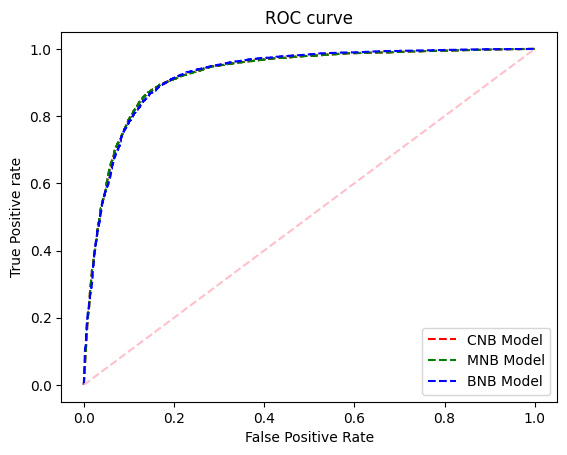

In [49]:
from sklearn.metrics import roc_curve

# predict probabilities for CNB, MNB, BNB models:
CNB_prob = cnb.predict_proba(X_test)
MNB_prob = mnb.predict_proba(X_test)
BNB_prob = bnb.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, CNB_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, MNB_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, BNB_prob[:,1], pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# auc scores
from sklearn.metrics import roc_auc_score
auc_CNB = roc_auc_score(y_test, CNB_prob[:,1])
auc_MNB = roc_auc_score(y_test, MNB_prob[:,1])
auc_BNB = roc_auc_score(y_test, BNB_prob[:,1])
print(auc_CNB, auc_MNB,auc_BNB)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='CNB Model')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MNB Model')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='BNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [51]:
accuracies = {
    'Multinomial Naive Bayes': mnb_acc,
    'Bernoulli Naive Bayes': bnb_acc,
    'Complement Naive Bayes': cnb_acc
}

for model, accuracy in accuracies.items():
  print(f'{model} accuracy is {accuracy}')


Multinomial Naive Bayes accuracy is 0.8577
Bernoulli Naive Bayes accuracy is 0.8505
Complement Naive Bayes accuracy is 0.8579


# r

After training our Naive-Bayes classifier on a subset of the IMDb 50k film dataset and evaluating its performance on the test set,i obtained the following results:

| Metrics   | Multinomial NB  | Bernoulli NB    | Complement NB   |
|-----------|-----------------|-----------------|-----------------|
|Accuracy   | 85.77%          | 85.05%          | 85.79%           |
|Precision  | 0: 84%, 1: 87%  | 0: 83%, 1: 87%  | 0: 84%, 1: 87%  |
|Recall     | 0: 88%, 1: 84%  | 0: 88%, 1: 82%  | 0: 88%, 1: 84%  |
|F1-score   | 0: 86%, 1: 86%  | 0: 85%, 1: 85%  | 0: 86%, 1: 86%  |

Analysis:

* Accuracy: All three classifiers achieved relatively high accuracy scores, ranging from 85.05% to 85.79%. This indicates that they are effective in correctly predicting the overall sentiment of movie reviews.

* Precision: The precision scores for both classes (0 and 1) are consistently high across all classifiers, ranging from 83% to 87%. This suggests that the classifiers perform well in correctly identifying positive and negative reviews without misclassifying too many instances.

* Recall: The recall scores vary slightly among the classifiers, particularly for class 1 (positive reviews). However, all classifiers maintain relatively high recall scores for both classes, indicating their ability to capture the majority of positive and negative instances in the dataset.

* F1-score: The F1-scores, which represent the harmonic mean of precision and recall, are also high for all classifiers, ranging from 85% to 86%. This indicates a good balance between precision and recall, further validating the classifiers' effectiveness.

Overall, the results demonstrate that all three Naive-Bayes classifiers - Multinomial NB, Bernoulli NB, and Complement NB - perform well in sentiment analysis on the IMDb 50k film dataset. Their high accuracy, precision, recall, and F1-scores indicate their capability to effectively predict the sentiment of movie reviews.